In [1]:
%matplotlib notebook

In [2]:
import pylab as pl
import numpy as np

### this code snippet will load the next cell with the global preamble

```
with open('preamble.py', 'r') as fh:
    preamble = fh.read()
get_ipython().set_next_input(preamble)
```

In [3]:
%matplotlib inline
import numpy as np
from astropy import units as u
import pylab as pl
pl.rcParams['figure.figsize'] = (16,8)
import sys
import glob
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube
import selfcal_heuristics
import spectral_cube
import os
os.chdir("/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/imaging_results")

In [41]:
import casatools
tb = casatools.table()
msmd = casatools.msmetadata()

In [85]:
caltable = '../W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_phase4_int.cal/'
tb.open(caltable)

True

In [86]:
okfields,notokfields = selfcal_heuristics.goodenough_field_solutions(caltable,
                                                                     minsnr=5)
print(okfields, notokfields)

[16, 17, 18, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 35] [11, 12, 13, 14, 15, 19, 20, 24, 29, 33, 34, 36, 37]


In [87]:
fieldOKmask = np.isin(data['FIELD_ID'], okfields)

In [88]:
msmd.open('../W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_selfcal.ms/')

True

In [89]:
tb.colnames()

['TIME',
 'FIELD_ID',
 'SPECTRAL_WINDOW_ID',
 'ANTENNA1',
 'ANTENNA2',
 'INTERVAL',
 'SCAN_NUMBER',
 'OBSERVATION_ID',
 'CPARAM',
 'PARAMERR',
 'FLAG',
 'SNR',
 'WEIGHT']

In [90]:
tb.ncols(), tb.nrows()

(13, 683920)

In [91]:
data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}

In [92]:
data['ANGLE'] = np.angle(data['CPARAM'])

In [93]:
fids = np.unique(data['FIELD_ID'])
print(fids)

[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37]


In [94]:
oids = np.unique(data['OBSERVATION_ID'])
print(oids)

[ 2  3 12]


In [95]:
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
print(spwids)

[12 13 14 15 16 17 18 19 20 21 22 23 72 73 74 75 76 77]


In [96]:
# which observations contain which fields?
for oid in oids:
    oid_match = data['OBSERVATION_ID'] == oid
    has_fid = [fid for fid in fids if np.any((data['FIELD_ID'] == fid) & oid_match)]
    print(f"OID {oid} has fields {has_fid}")

OID 2 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
OID 3 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
OID 12 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


fids_12m = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44]fids_7m = [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]


In [97]:
fids_12m = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]

In [98]:
print({col: data[col].shape for col in data})

{'TIME': (683920,), 'FIELD_ID': (683920,), 'SPECTRAL_WINDOW_ID': (683920,), 'ANTENNA1': (683920,), 'ANTENNA2': (683920,), 'INTERVAL': (683920,), 'SCAN_NUMBER': (683920,), 'OBSERVATION_ID': (683920,), 'CPARAM': (2, 1, 683920), 'PARAMERR': (2, 1, 683920), 'FLAG': (2, 1, 683920), 'SNR': (2, 1, 683920), 'ANGLE': (2, 1, 683920)}


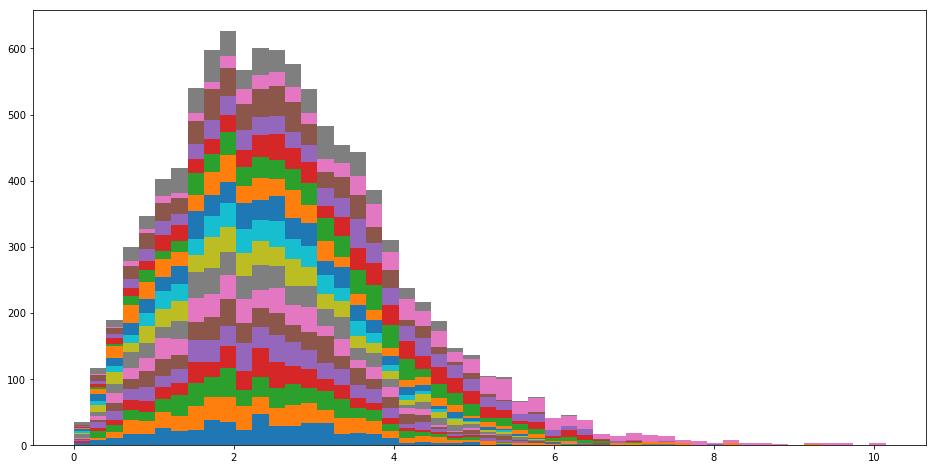

In [99]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, (data['FIELD_ID'] == 14) & (OK[0,0,:]) & (data['SPECTRAL_WINDOW_ID'] == spwid)]
          for spwid in spwids]

H,L,P = pl.hist(toplot, bins=50, stacked=True)

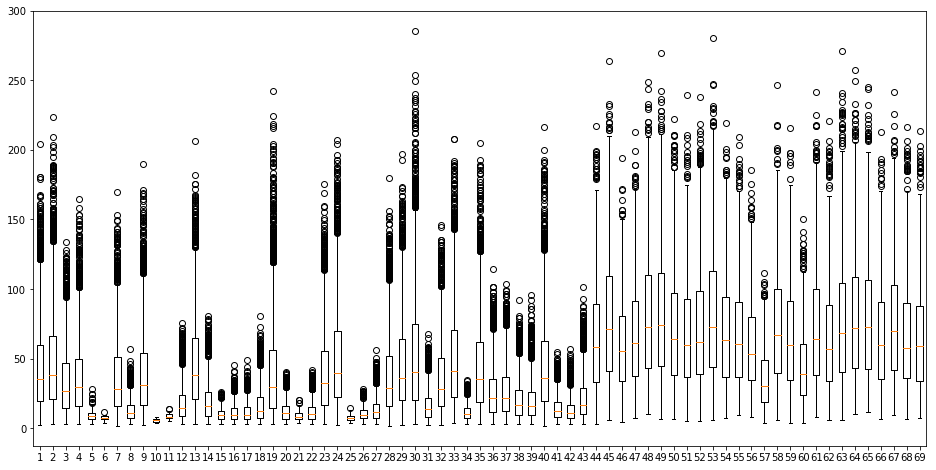

In [100]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, fieldOKmask & (OK[0,0,:]) & (data['ANTENNA1'] == ant)]
          for ant in np.unique(data['ANTENNA1'])]
toplot = [x for x in toplot if len(x) > 0]

_ = pl.boxplot(toplot)

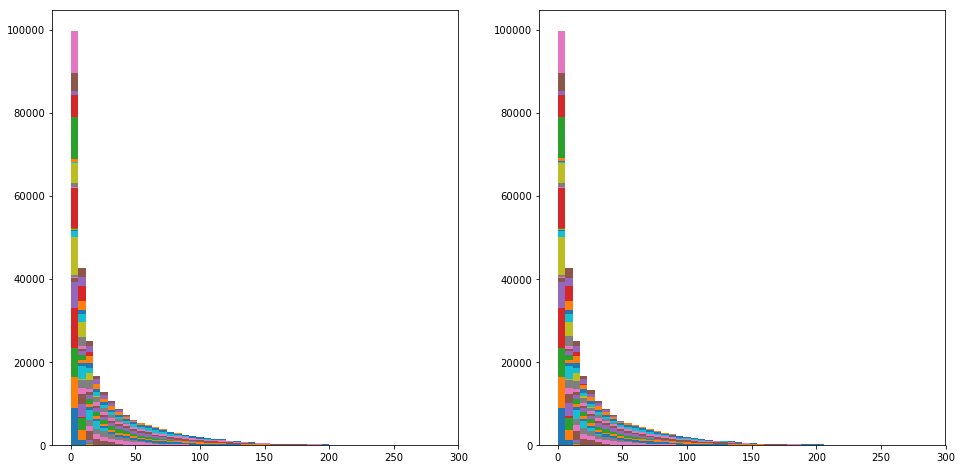

In [101]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
          for fid in fids_12m]

pl.subplot(1,2,1)
H,L,P = pl.hist(toplot, bins=50, stacked=True)

toplot = [data['SNR'][1,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
          for fid in fids_12m]

pl.subplot(1,2,2)
H,L,P = pl.hist(toplot, bins=50, stacked=True)

Per-field stats:

In [102]:
for fid in fids_12m:
    dat = data['SNR'][1,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
    ang = data['ANGLE'][1,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
    print(f"fid={fid:03d} mean={dat.mean():10.2f} median={np.median(dat):10.2f} std={dat.std():10.2f} angle_rms={ang.std():10.2f}")

fid=011 mean=      3.35 median=      2.90 std=      2.12 angle_rms=      0.79
fid=012 mean=      4.14 median=      3.55 std=      2.58 angle_rms=      0.78
fid=013 mean=      4.81 median=      4.03 std=      3.16 angle_rms=      0.74
fid=014 mean=      2.73 median=      2.56 std=      1.43 angle_rms=      0.88
fid=015 mean=      5.09 median=      4.25 std=      3.46 angle_rms=      0.74
fid=016 mean=     15.91 median=     13.99 std=      8.91 angle_rms=      0.82
fid=017 mean=     33.42 median=     30.23 std=     21.04 angle_rms=      0.87
fid=018 mean=     24.10 median=     21.44 std=     14.95 angle_rms=      0.86
fid=019 mean=      2.88 median=      2.69 std=      1.63 angle_rms=      0.75
fid=020 mean=     13.14 median=     12.02 std=      7.30 angle_rms=      0.77
fid=021 mean=     56.12 median=     53.84 std=     35.65 angle_rms=      0.97
fid=022 mean=     57.82 median=     50.29 std=     41.17 angle_rms=      0.83
fid=023 mean=     31.98 median=     28.53 std=     20.30 angle_r

In [103]:
# assumption: np.unique(ant1) is an ordered 0...82 list
antnames = {k:v for k,v in enumerate(msmd.antennanames(np.unique(data['ANTENNA1'])))}

In [104]:
antdist = {k:(msmd.antennaoffset(k)['latitude offset']['value']**2 + msmd.antennaoffset(k)['longitude offset']['value']**2)**0.5
           for k in antnames}

In [105]:
antstats = {}
for antid in np.unique(data['ANTENNA1']):
    msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask
    if np.any(msk):
        dat = data['SNR'][1,0, msk]
        ang = data['ANGLE'][1,0, msk]
        print(f"antenna={antnames[antid]} dist={antdist[antid]:6.1f} mean={dat.mean():10.2f} median={np.median(dat):10.2f} std={dat.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
        antstats[antid] = {'mean':dat.mean(),
                           'median':np.median(dat),
                           'std': dat.std(),
                           'angle_rms': ang.std(),
                          }

antenna=DA41 dist= 648.2 mean=     42.93 median=     34.34 std=     31.28 angle_rms=      7.81
antenna=DA42 dist= 671.1 mean=     48.11 median=     38.27 std=     35.84 angle_rms=     41.34
antenna=DA43 dist= 827.1 mean=     34.84 median=     28.02 std=     24.96 angle_rms=     66.26
antenna=DA44 dist= 615.7 mean=     33.57 median=     26.98 std=     24.21 angle_rms=     34.31
antenna=DA45 dist= 563.3 mean=      9.44 median=      8.73 std=      4.04 angle_rms=     79.42
antenna=DA46 dist= 399.9 mean=      7.15 median=      7.23 std=      1.74 angle_rms=     62.97
antenna=DA47 dist= 707.5 mean=     37.31 median=     28.52 std=     28.40 angle_rms=     46.53
antenna=DA48 dist= 508.9 mean=     12.44 median=     10.38 std=      7.68 angle_rms=     70.71
antenna=DA49 dist= 665.5 mean=     39.91 median=     31.13 std=     30.52 angle_rms=     24.62
antenna=DA50 dist= 960.6 mean=      5.86 median=      5.68 std=      1.46 angle_rms=     85.41
antenna=DA51 dist= 724.2 mean=      7.74 median=  

In [106]:
np.unique(data['SPECTRAL_WINDOW_ID'])

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 72, 73, 74, 75, 76,
       77], dtype=int32)

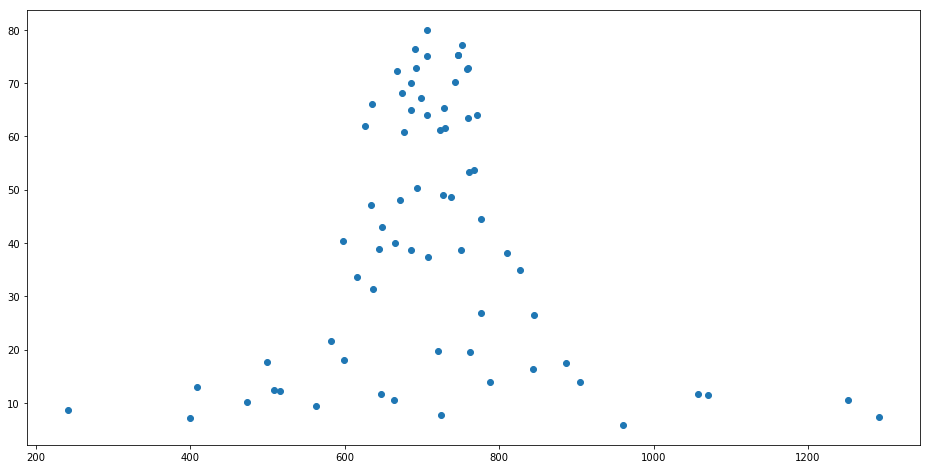

In [107]:
pl.plot([antdist[ant] for ant in antstats],
        [antstats[ant]['mean'] for ant in antstats],
        'o')

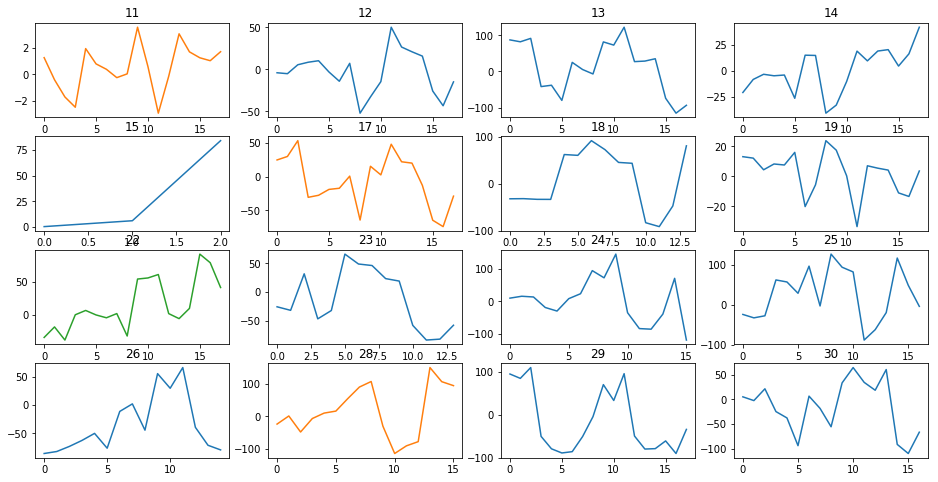

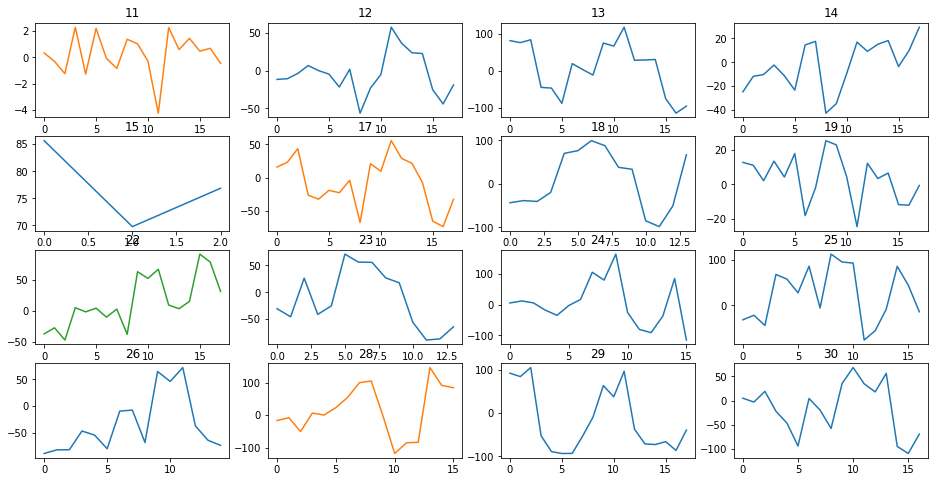

In [22]:
fid = 31 # best s/n
nant = len(np.unique(data['ANTENNA1']))
for pol in (0,1):
    pl.figure()
    cnt = 0

    for ii,ant in enumerate(np.unique(data['ANTENNA1'])):
        ax = pl.subplot(4, 4, cnt+1)
        msk = (data['ANTENNA1'] == ant) & (data['FIELD_ID'] == fid) & (OK[pol,0,:]) & (data['SPECTRAL_WINDOW_ID'] == 12)
        ax.plot(data['ANGLE'][pol,0,msk]*180/np.pi)
        ax.set_title(str(ant))
        if np.any(msk):
            cnt += 1
        if cnt > 15:
            break


In [23]:
data['ANGLE'].shape

(2, 1, 685414)

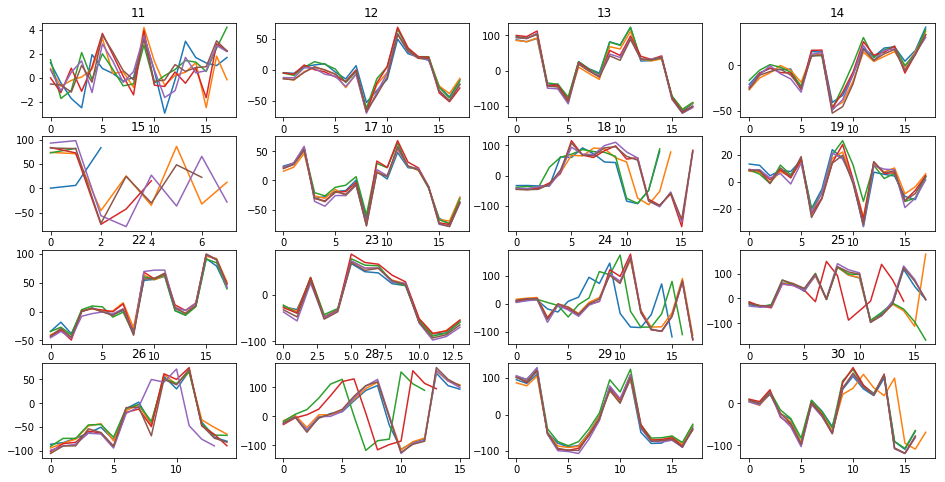

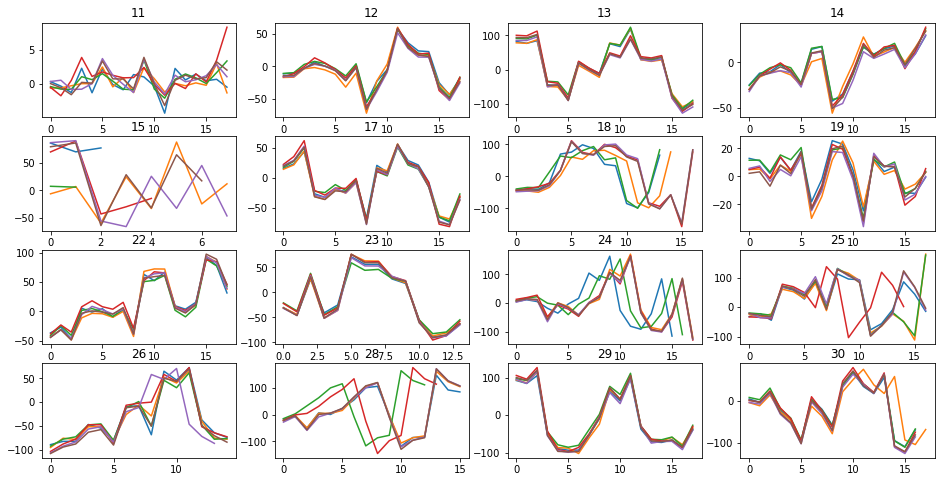

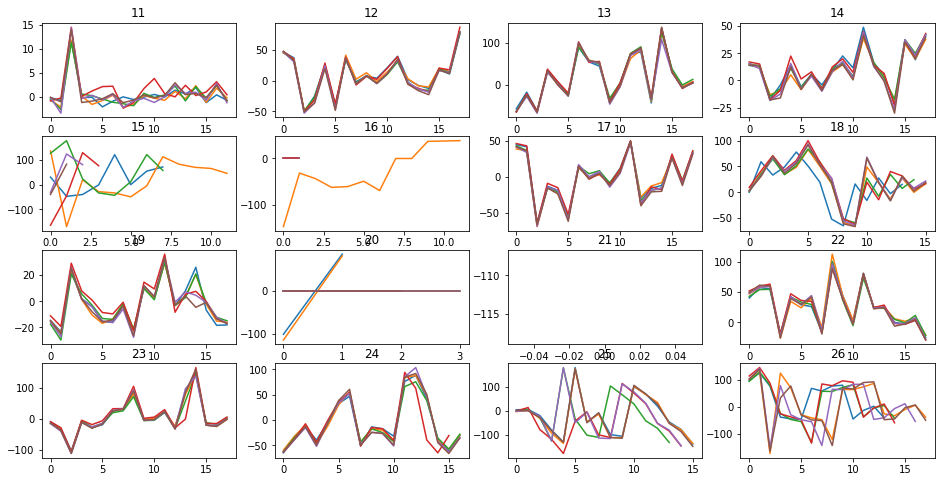

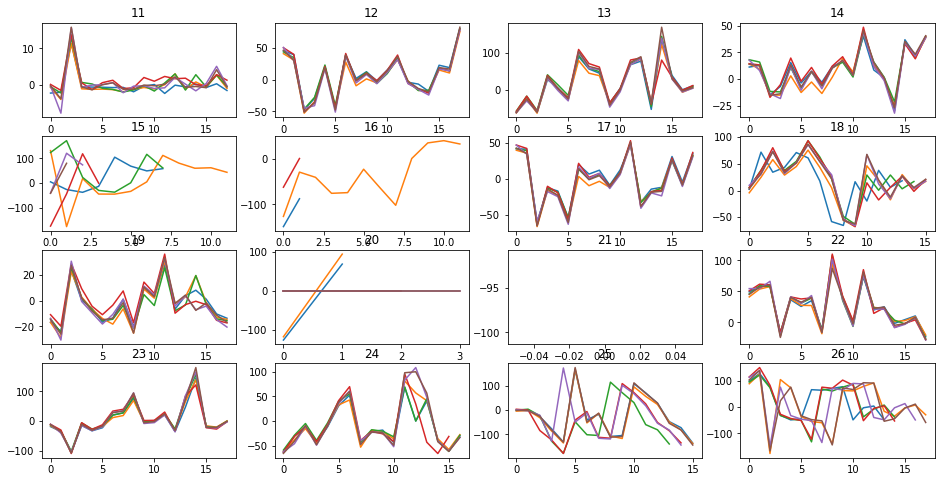

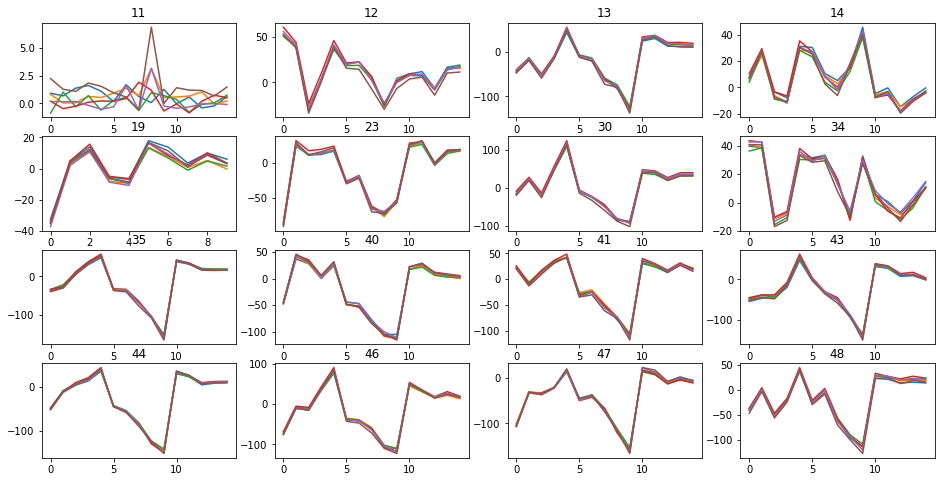

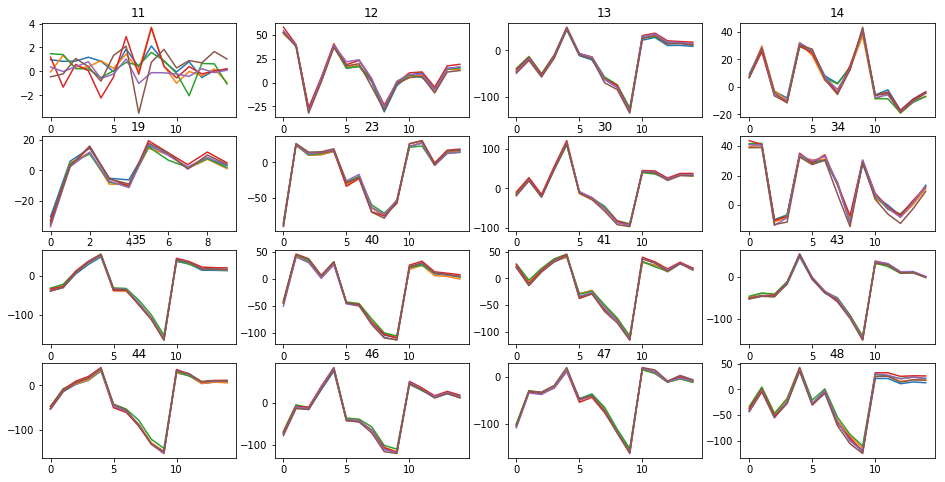

In [24]:
fid = 31 # best s/n
nant = len(np.unique(data['ANTENNA1']))
for oid in np.unique(data['OBSERVATION_ID']):
    for pol in (0,1):
        pl.figure()
        cnt = 0

        for ii,ant in enumerate(np.unique(data['ANTENNA1'])):
            ax = pl.subplot(4, 4, cnt+1)
            msk = (data['ANTENNA1'] == ant) & (data['FIELD_ID'] == fid) & (OK[pol,0,:]) & (data['OBSERVATION_ID'] == oid)
            spws = data['SPECTRAL_WINDOW_ID'][msk]
            
            
            if np.any(msk):
                cnt += 1
                for spw in np.unique(spws):
                    smsk = msk & (data['SPECTRAL_WINDOW_ID'] == spw)
                    time = data['TIME'][smsk] 
                    time -= np.min(time)
                    time /= 60
                    ang = data['ANGLE'][pol,0,smsk]*180/np.pi
                    srt = np.argsort(time)
                    #ax.plot(time[srt], ang[srt], '.')
                    ax.plot(ang[srt], '-')
                ax.set_title(str(ant))
            if cnt > 15:
                break
